# Scaling of NLME inference with number of measured individuals

In [1]:
import os
import pickle
import string

import arviz as az
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
sns.set_theme()

Import data

In [4]:
n_ids_per_t

[[10, 15, 20, 25, 30, 35, 40, 45, 50],
 [10, 15, 20, 25, 30, 35, 40, 45, 50],
 [10, 15, 20, 25, 30, 35, 40, 45, 50],
 [10, 15, 20, 25, 30, 35, 40, 45, 50]]

In [2]:
# Import hierarchical exponential growth model inference data
models = [
    'hierarchical_logistic_growth_model',
    'hierarchical_logistic_growth_model_pfi',
    'growth_factor_model_3_fixed_params',
    'growth_factor_model_3_fixed_params_pfi',
]
directory = os.getcwd()

# Import posterior evaluation time
n_ids_per_t = []
eval_time = []
for model in models:
    n, t = pickle.load(open(
        directory + '/derived_data/posteriors/%s_eval_time.p' % model, 'rb'))
    n_ids_per_t.append(n[:-1])
    eval_time.append(t[:-1])


# Import number of posterior evaluations for 1000 MCMC steps
evaluations = [[] for _ in models]
warmup = 500
iter_per_log = 20
warmup_index = 500 // 20
n_iterations = 1000
n_chains = 3
for idm, model in enumerate(models):
    for n_ids in n_ids_per_t[idm]:
        if n_ids == 55:
            continue
        # Load data
        data = pd.read_csv(
            directory + '/derived_data/posteriors/%s_%d.csv' % (model, n_ids))
        # Get final number of evaluations and final run time
        # (final valid entry is determined by first NaN entry)
        final_index = data.isna().any(axis=1)[warmup_index:].argmax()
        final_iter = n_iterations
        if final_index > 0:
            # Final index is smaller than n_iterations
            final_iter = data.iloc[warmup_index+final_index]['Iter.']
        mask = data['Iter.'] == final_iter
        e = data[mask]['Eval.'].values[0]
        # Subtract warm up
        mask = data['Iter.'] == warmup
        e -= data[mask]['Eval.'].values[0]
        # Estimate number of evaluations and run time for 1000 iterations
        # of a single chain
        e = e / (final_iter - warmup) * n_iterations / n_chains
        # Append to container
        evaluations[idm].append(e)

In [10]:
data[data['Iter.'] == 500]['Eval.'].values[0]

458643

Visualise results

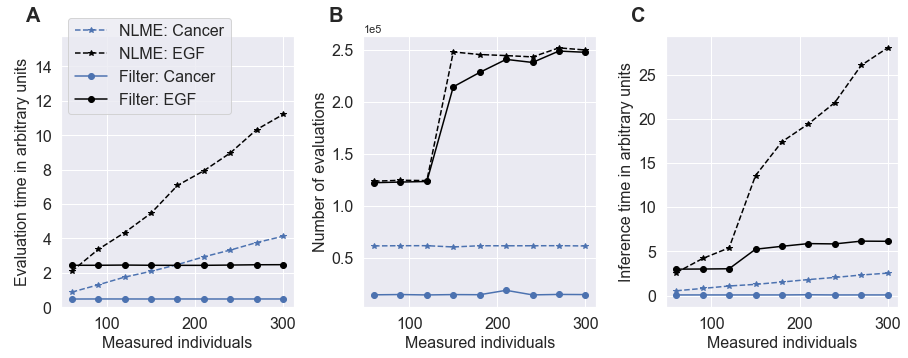

In [3]:
fig = plt.figure(figsize=(15, 5))
grid = gridspec.GridSpec(1, 3, wspace=0.3)
ax1 = plt.Subplot(fig, grid[0])
ax2 = plt.Subplot(fig, grid[1])
ax3 = plt.Subplot(fig, grid[2])
for ax in [ax1, ax2, ax3]:
    fig.add_subplot(ax)

# Add data
colors = sns.color_palette()
ax1.plot(
    np.array(n_ids_per_t[0]) * 6, np.array(eval_time[0]) * 100, color=colors[0],
    label='NLME: Cancer', marker='*', linestyle='--')
ax2.plot(
    np.array(n_ids_per_t[0]) * 6, evaluations[0],
    color=colors[0], marker='*', linestyle='--')
ax3.plot(
    np.array(n_ids_per_t[0]) * 6,
    np.array(evaluations[0]) * np.array(eval_time[0]) / 1000,
    color=colors[0], marker='*', linestyle='--')
ax1.plot(
    np.array(n_ids_per_t[1]) * 6, np.array(eval_time[1]) * 100,
    marker='o', color=colors[0])
ax2.plot(
    np.array(n_ids_per_t[1]) * 6, evaluations[1], label='Filter: Cancer',
     marker='o', color=colors[0])
ax3.plot(
    np.array(n_ids_per_t[1]) * 6,
    np.array(evaluations[1]) * np.array(eval_time[1]) / 1000,
    color=colors[0], marker='o')
ax1.plot(
    np.array(n_ids_per_t[2]) * 6, np.array(eval_time[2]) * 100, color='black',
    label='NLME: EGF', marker='*', linestyle='--')
ax2.plot(
    np.array(n_ids_per_t[2]) * 6, evaluations[2],
    color='black', marker='*', linestyle='--')
ax3.plot(
    np.array(n_ids_per_t[2]) * 6,
    np.array(evaluations[2]) * np.array(eval_time[2]) / 1000,
    color='black', marker='*', linestyle='--')
ax1.plot(
    np.array(n_ids_per_t[3]) * 6, np.array(eval_time[3]) * 100,
    marker='o', color='black')
ax2.plot(
    np.array(n_ids_per_t[3]) * 6, evaluations[3], label='Filter: EGF',
     marker='o', color='black')
ax3.plot(
    np.array(n_ids_per_t[3]) * 6,
    np.array(evaluations[3]) * np.array(eval_time[3]) / 1000,
    color='black', marker='o')

# Add labels
fontsize = '16'
ax1.set_xlabel('Measured individuals', fontsize=fontsize)
ax2.set_xlabel('Measured individuals', fontsize=fontsize)
ax3.set_xlabel('Measured individuals', fontsize=fontsize)
ax1.set_ylabel('Evaluation time in arbitrary units', fontsize=fontsize)
ax2.set_ylabel('Number of evaluations', fontsize=fontsize)
ax3.set_ylabel('Inference time in arbitrary units', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax1.set_ylim([0, 15.8])
ax2.tick_params(labelsize=fontsize)
ax3.tick_params(labelsize=fontsize)
ax2.ticklabel_format(axis='y', style='scientific', scilimits=(0, 2),)
fig.legend(fontsize=fontsize, loc=[0.075, 0.68])

# Label subplot groups
ax1.text(
    -0.15, 1.05, string.ascii_uppercase[0], transform=ax1.transAxes, size=20,
    weight='bold')
ax2.text(
    -0.15, 1.05, string.ascii_uppercase[1], transform=ax2.transAxes, size=20,
    weight='bold')
ax3.text(
    -0.15, 1.05, string.ascii_uppercase[2], transform=ax3.transAxes, size=20,
    weight='bold')

plt.savefig('nlme_inference_scaling.pdf', bbox_inches='tight')
plt.show()

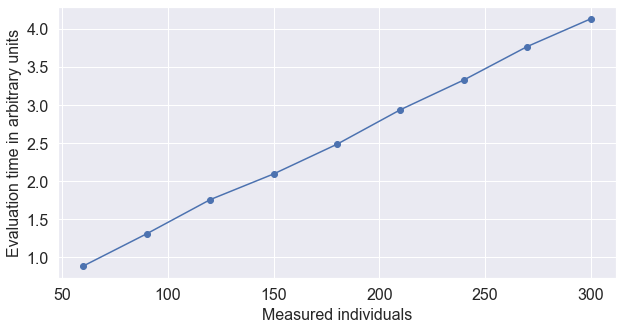

In [9]:
fig = plt.figure(figsize=(10, 5))
grid = gridspec.GridSpec(1, 1)
ax1 = plt.Subplot(fig, grid[0])
for ax in [ax1]:
    fig.add_subplot(ax)

# Add data
colors = sns.color_palette()
ax1.plot(
    np.array(n_ids_per_t[0]) * 6, np.array(eval_time[0]) * 100, color=colors[0],
    marker='o', linestyle='solid')

# Add labels
fontsize = '16'
ax1.set_xlabel('Measured individuals', fontsize=fontsize)
ax1.set_ylabel('Evaluation time in arbitrary units', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)

plt.savefig('nlme_inference_scaling.pdf', bbox_inches='tight')
plt.show()

Model 1: complexity of posterior surface does not scale with the number of measured individuals. PFI seems to translate inference problem into simpler problem. Asymptotic behaviour is dominated by posterior evaluation costs.
Model 2: Same as Model 1, but there also is a clear complexity increase from 120 to 150 measured individuals. Based on the fact that PFI displays this increase as well, it can't be the increasing number of individual-level parameters. So most likely the observed population measurement distribution enforces a more complex posterior distribution. (Check by looking at posteriors)

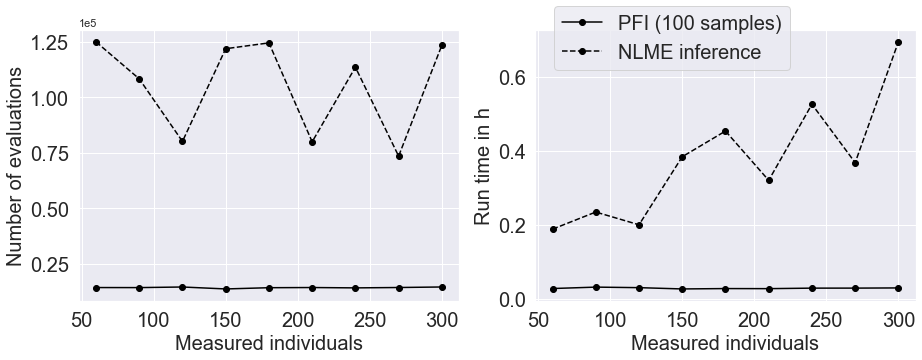

In [242]:
fig = plt.figure(figsize=(15, 5))
grid = gridspec.GridSpec(1, 1)
ax1 = plt.Subplot(fig, grid[0])
ax2 = plt.Subplot(fig, grid[1])
for ax in [ax1, ax2]:
    fig.add_subplot(ax)

# Add data
n_ids = np.array(n_ids_per_t) * 6
ax1.plot(
    n_ids, evaluations[1], color='black', label='PFI (100 samples)',
     marker='o')
ax2.plot(
    n_ids, np.array(run_time[1]) / 3600, label='PFI (100 samples)',
    color='black', marker='o')
ax1.plot(
    n_ids, evaluations[0], label='NLME inference', color='black',
     marker='o', linestyle='--')
ax2.plot(
    n_ids, np.array(run_time[0]) / 3600, label='NLME inference',
    color='black', marker='o', linestyle='--')
# ax1.plot(n_ids, evaluations[1], label='EGF model: 4 fixed params.', marker='o')
# ax2.plot(n_ids, np.array(run_time[1]) / 3600, label='EGF model: 4 fixed params.', marker='o')
# ax1.plot(n_ids, evaluations[2], label='EGF model: 3 fixed params.', marker='o')
# ax2.plot(n_ids, np.array(run_time[2]) / 3600, label='EGF model: 3 fixed params.', marker='o')
# ax1.plot(n_ids, evaluations[3], label='EGF model: 2 fixed params.', marker='o')
# ax2.plot(n_ids, np.array(run_time[3]) / 3600, label='EGF model: 2 fixed params.', marker='o')
# ax1.plot(n_ids[:4], evaluations[4], label='EGF model: 1 fixed param.')
# ax2.plot(n_ids[:4], np.array(run_time[4]) / 3600, label='EGF model: 1 fixed param.')

# Add labels
fontsize = '20'
ax1.set_xlabel('Measured individuals', fontsize=fontsize)
ax2.set_xlabel('Measured individuals', fontsize=fontsize)
ax1.set_ylabel('Number of evaluations', fontsize=fontsize)
ax2.set_ylabel('Run time in h', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax2.tick_params(labelsize=fontsize)
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 2))
plt.legend(fontsize=fontsize, loc=[0.05, 0.85])

plt.savefig('nlme_inference_scaling_poster.pdf', bbox_inches='tight')
plt.show()

Time measurement is not reliable enough. Instead, estimate time of posterior evaluations more carefully and multiply by number of evaluations.

#### Effective sample size scaling

In [123]:
# Import hierarchical exponential growth model inference data
models = [
    'hierarchical_exponential_growth_model',
]
directory = os.getcwd()

# Import posterior evaluation time
warmup = 500
n_iterations = 1000
divergent = []
ess = []
nids_per_t = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
for model in models:
    e = []
    d = []
    for nids in nids_per_t:
        samples = xr.load_dataset(
            directory + '/derived_data/posteriors/%s_%d_samples.nc'
            % (model, nids))
        samples = samples.sel(draw=slice(warmup, n_iterations))
        sample_size = az.ess(samples)

        # Average over ESS of population parameters
        temp = []
        for v in sample_size.data_vars:
            v = sample_size[v].values
            if v.ndim > 0:
                continue
            temp.append(v)
        e.append(np.min(temp) / (n_iterations - warmup))

        # Check whether divergent iterations occured after the warm up
        d.append(
            np.any(samples.attrs['divergent iterations chain 0'] > warmup))
    ess.append(e)
    divergent.append(d)


Plot posterior evaluation time and ESS.
Mark runs with divergent iterations with a 'x'.